In [1]:
import jax
from jax import custom_jvp, pure_callback, vmap, grad, jit

import jax.numpy as jnp
from jax.scipy.special import bessel_jn

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.special import jv

from jax.config import config
config.update("jax_enable_x64", True) # this is *absolutely essential* for the jax bessel function to be numerically stable


In [26]:
def beta1(x):
    '''
    beta function from https://www.cl.cam.ac.uk/~jrh13/papers/bessel.pdf

    Parameters
    ----------
    x : float
        argument of the bessel function

    Returns
    -------
    float
        value of the bessel function
    '''

    return (1. + 3./16./jnp.abs(x)**2 -(99./512.)/jnp.abs(x)**4 + (6597./8192.)/jnp.abs(x)**6 - (4057965./524288.)/jnp.abs(x)**8)

def alpha1(x):
    '''
    alpha function from https://www.cl.cam.ac.uk/~jrh13/papers/bessel.pdf

    Parameters
    ----------
    x : float
        argument of the bessel function

    Returns
    -------
    float
        value of the bessel function
    '''
    return -3./8/jnp.abs(x) + (21./128.)/jnp.abs(x)**3 - 1899./5120/jnp.abs(x)**5 + (543483./229376.)/jnp.abs(x)**7 - (8027901./262144.)/jnp.abs(x)**9

def j1_large(x):
    '''
    j1 implmementation from https://www.cl.cam.ac.uk/~jrh13/papers/bessel.pdf, using the alpha and beta functions to calculate the series for large x

    Parameters
    ----------
    x : float
        argument of the bessel function

    Returns
    -------
    float
        value of the bessel function

    '''


    return jnp.sign(x)*(jnp.sqrt(2/np.pi/jnp.abs(x))*beta1(jnp.abs(x))*jnp.cos(jnp.abs(x) - (3./4.)*np.pi - alpha1(jnp.abs(x))))

def j1(x):
    '''
    Implementation of the first order bessel function of the first kind, using jax default for small arguments and a series expansion for large arguments

    Parameters
    ----------
    x : float
        argument of the bessel function

    Returns
    -------
    float
        value of the bessel function
        
    '''
    # use jax to compute the first order bessel function, but for very small values return x
    tol = 1e-4
    safe = jnp.where(jnp.abs(x)<tol, 5., x) # cast small values to a dummy value that will not give a nan

    # write a series of nested where statements that use large n_iter only for large arguments, and at for x>30 it uses j1_large

    return jnp.where(jnp.abs(x) < tol, 0.5*x, jnp.where(jnp.abs(x) < 5., bessel_jn(safe,v=1,n_iter=24)[1], 
            jnp.where(jnp.abs(x) < 20., bessel_jn(safe,v=1,n_iter=48)[1], 
                jnp.where(jnp.abs(x) < 30., bessel_jn(safe,v=1,n_iter=64)[1], j1_large(safe)
                    ))))        

In [27]:
f = jit(vmap(j1))
gs  = jit(vmap(grad(j1)))

In [28]:
x = np.linspace(0,100,1000)

In [29]:
%timeit f(x)
%timeit gs(x)

140 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
864 µs ± 94.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
grad(j1)(-10.) # test good gradients for small values

Array(-0.25028304, dtype=float64, weak_type=True)

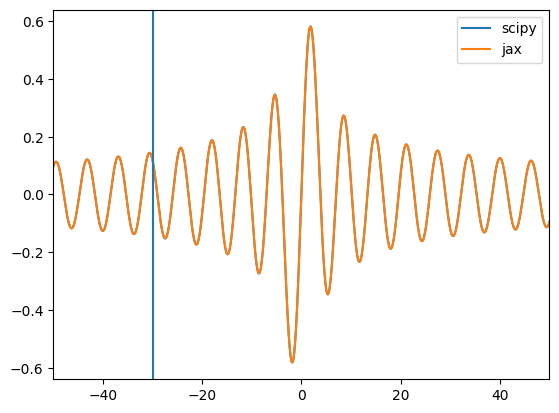

In [31]:
x = np.linspace(-500, 500, 10000)

y = jv(1, x)
yy = j1(x)
# yy_large = j1_large(x)
gg = gs(x)
plt.plot(x, y, label="scipy")
plt.plot(x, yy, label="jax")
# plt.plot(x, yy_large, label="jax large")
plt.legend()
plt.xlim(-50,50)
plt.axvline(-30)

Text(0.5, 1.0, 'Derivative')

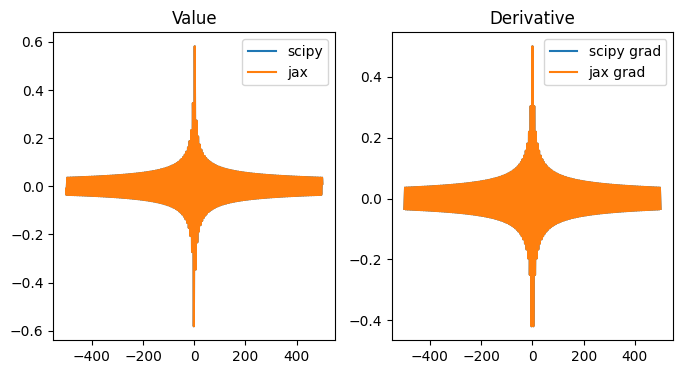

In [34]:
## do the plot of the value and the derivative, in subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),sharex=True)

ax1.plot(x, y, label="scipy")
ax1.plot(x, yy, label="jax")
ax1.legend()
ax1.set_title('Value')

gscipy = 0.5 * (jv(0, x) - jv(2, x))
ax2.plot(x, gscipy, label="scipy grad")
ax2.plot(x, gg, label="jax grad")
gscipy = 0.5 * (jv(0, x) - jv(2, x))
ax2.legend()
ax2.set_title("Derivative")
# ax1.set_xlim(0, 25)

Text(0.5, 1.0, 'Derivative')

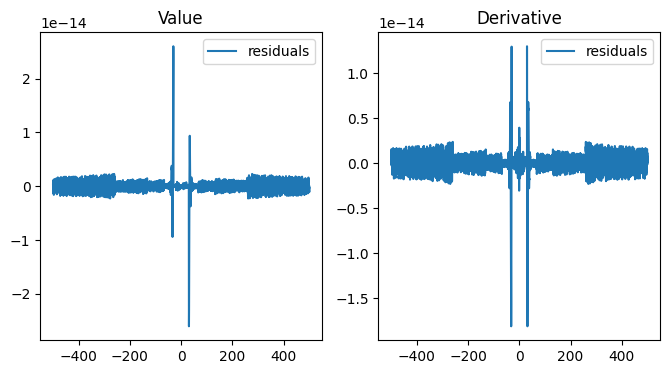

In [35]:
## do the plot of the value and the derivative, in subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),sharex=True)

ax1.plot(x, y-yy, label="residuals")
ax1.legend()
ax1.set_title('Value')

ax2.plot(x, gg-gscipy, label="residuals")
gscipy = 0.5 * (jv(0, x) - jv(2, x))
ax2.legend()
ax2.set_title("Derivative")
# ax1.set_xlim(0, 25)

In [36]:
(np.all(np.isfinite(gg)),np.all(np.isfinite(yy)))

(True, True)